In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Loading Data and Summary Statistics 

In [3]:
# df = pd.read_csv(r"/Users/NexusMacBookProYeo/Desktop/Y4S2/BT4211/data.csv", encoding="ISO-8859-1")
# df = pd.read_csv(r"C:\Users\limng\Documents\Y4S2\BT4211\proj\BT4211_Group7\data.csv", encoding="ISO-8859-1")
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
#summary for numerical variables
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
#summary for categegorical variables
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


# Data Preparation - Cleaning and Transformation

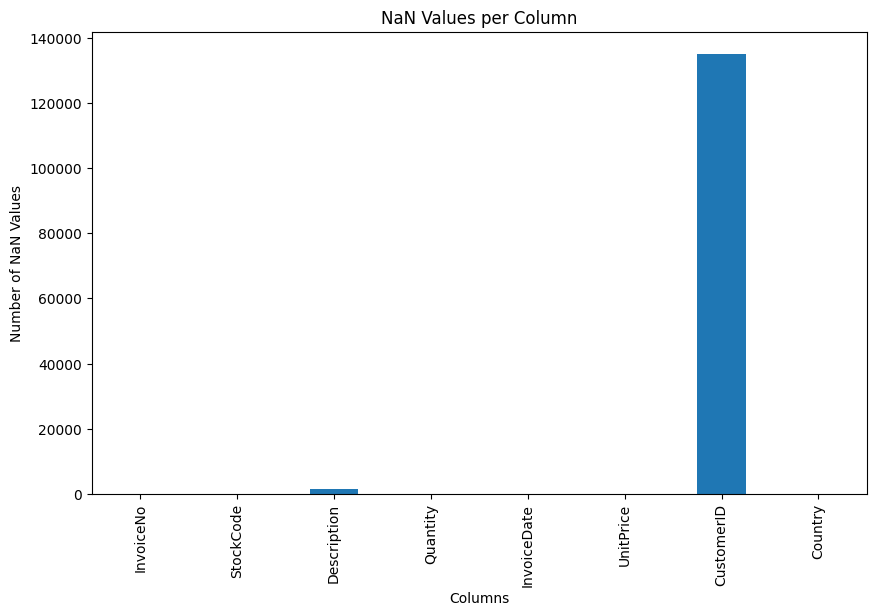

In [6]:
#Handling missing values
nan_counts = df.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6), title='NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

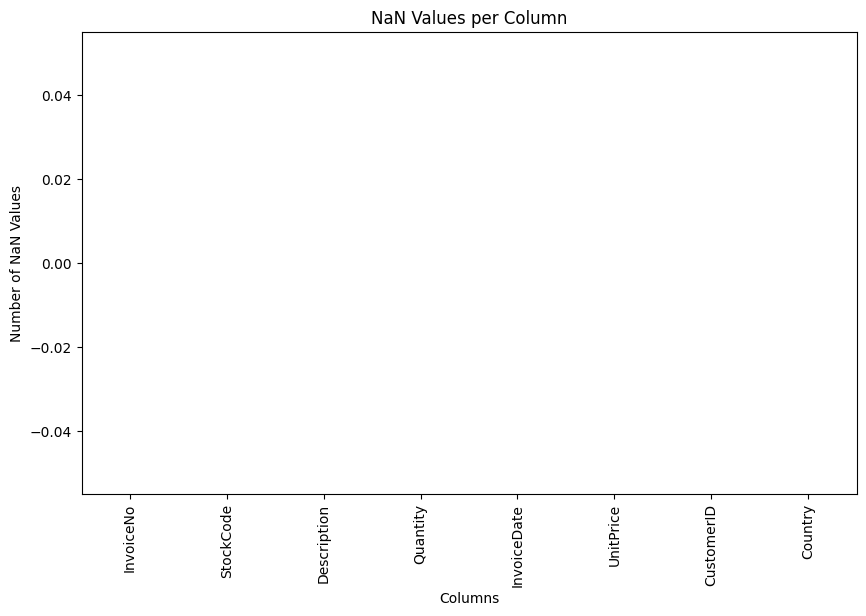

In [7]:
#drop missing values and verify that such rows have been dropped
df.dropna(inplace=True)
nan_counts = df.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6), title='NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

In [8]:
#Handling duplicates
duplicated_rows = df[df.duplicated()]
duplicated_rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


# EDA

In [11]:
# #Stockcode anomalies
# import matplotlib.pyplot as plt

# # Calculate the length of each Stockcode value
# # Calculate the length of each Stockcode value
# stockcode_lengths = df['StockCode'].str.len()

# # Count the occurrences of each unique length
# length_counts = stockcode_lengths.value_counts().reset_index()
# length_counts.columns = ['Length', 'Count']

# # Sort by length for better presentation
# length_counts = length_counts.sort_values(by='Length')

# # Display the table
# print(length_counts)


In [12]:
# df[df['StockCode']=="POST"]


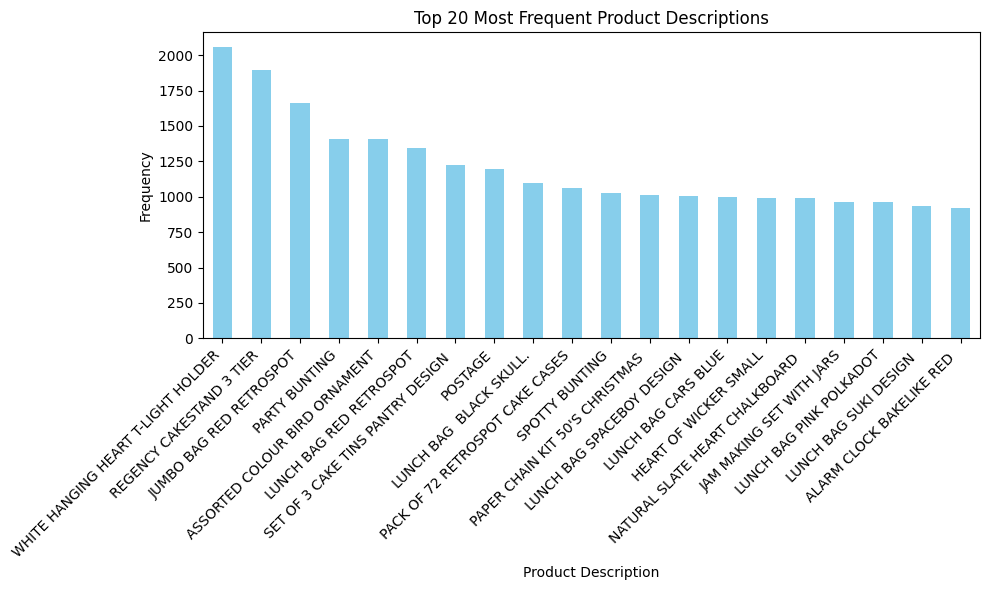

In [13]:
#EDA for Discription 
# Get the top 20 most frequent values in the product descriptions column
top_20_descriptions = df['Description'].value_counts().head(20)

# Plot the top 20 most frequent values
plt.figure(figsize=(10, 6))
top_20_descriptions.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Product Descriptions')
plt.xlabel('Product Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
#Investigating UnitPrice Discrepancies
df['UnitPrice'].describe()

count    401604.000000
mean          3.474064
std          69.764035
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

In [15]:
df.loc[df['UnitPrice'] > 1000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45622,C540271,M,Manual,-1,1/6/2011 11:51,1126.00,12503.0,Spain
73446,C542348,M,Manual,-1,1/27/2011 12:09,1715.85,12539.0,Spain
117052,C546325,M,Manual,-1,3/11/2011 10:15,1687.17,14911.0,EIRE
117053,C546327,M,Manual,-1,3/11/2011 10:18,1687.17,14911.0,EIRE
117054,546328,M,Manual,1,3/11/2011 10:19,1687.17,14911.0,EIRE
117055,546329,M,Manual,1,3/11/2011 10:22,1687.17,14911.0,EIRE
144826,548813,M,Manual,1,4/4/2011 13:03,2382.92,12744.0,Singapore
144828,548813,M,Manual,1,4/4/2011 13:03,1252.95,12744.0,Singapore
144829,548820,M,Manual,1,4/4/2011 13:04,2053.07,12744.0,Singapore
144831,C548830,M,Manual,-1,4/4/2011 13:08,2382.92,12744.0,Singapore


In [16]:
##MIGHT USE TO EVENTUALLY DROP ROWS WITH USELESS DESCRIPTIONS
# lowercase_descriptions = df['Description'].unique()
# lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# # Print the unique descriptions containing lowercase characters
# print("The unique descriptions containing lowercase characters are:")
# print("-"*60)
# for desc in lowercase_descriptions:
#     print(desc)

In [17]:
#Investigating anomalies in StockCode, as shown above, stockcodes usually contain numeric values, however, all the rows with extreme values contain only alphabets in stockcode
no_numeric_mask = ~df['StockCode'].str.contains(r'\d')

# Use the boolean mask to filter the DataFrame
rows_with_no_numeric = df[no_numeric_mask]

rows_with_no_numeric['StockCode'].unique()


array(['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [18]:
df = df[df['StockCode'].str.contains(r'\d')]

In [19]:
df['UnitPrice'].describe()

count    399823.000000
mean          2.923285
std           4.537682
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [20]:
#check if there are any exisiting columns with unitprice 0
df[df['UnitPrice']==0]
df = df[df['UnitPrice'] != 0]


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399790 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    399790 non-null  object 
 1   StockCode    399790 non-null  object 
 2   Description  399790 non-null  object 
 3   Quantity     399790 non-null  int64  
 4   InvoiceDate  399790 non-null  object 
 5   UnitPrice    399790 non-null  float64
 6   CustomerID   399790 non-null  float64
 7   Country      399790 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.5+ MB


# FEATURE ENGINEERING -RFM

## RECENCY

In [22]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

customer_data

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4357,18280.0,277
4358,18281.0,180
4359,18282.0,7
4360,18283.0,3


## FREQUENCY 

In [23]:
#total transactions made by each customer
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [24]:
num_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
num_transactions.rename(columns = {"InvoiceNo": "Num_Transactions"}, inplace = True)
# num_transactions
customer_data = pd.merge(customer_data, num_transactions, on="CustomerID")
customer_data


,CustomerID,Days_Since_Last_Purchase,Num_Transactions
0,12346.0,325,2
1,12347.0,2,7
2,12348.0,75,4
3,12349.0,18,1
4,12350.0,310,1
...,...,...,...
4357,18280.0,277,1
4358,18281.0,180,1
4359,18282.0,7,3
4360,18283.0,3,16


## MONETARY

In [25]:
#total spending for each customer
df.loc[df['Quantity'] < 0, 'Sales'] = 0
df['Sales'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Sales'].sum().reset_index()
total_spend.rename(columns={"Sales":"Total_Spending"}, inplace=True)

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')



In [26]:
#total quantity of products purchased per customer
total_quantity = df.groupby('CustomerID')['Quantity'].sum()
customer_data = pd.merge(customer_data, total_quantity, on='CustomerID')
customer_data.rename(columns = {"Quantity":"Total_Quantity"}, inplace=True)
customer_data


,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity
0,12346.0,325,2,0.00,0
1,12347.0,2,7,4310.00,2458
2,12348.0,75,4,1437.24,2332
3,12349.0,18,1,1457.55,630
4,12350.0,310,1,294.40,196
...,...,...,...,...,...
4357,18280.0,277,1,180.60,45
4358,18281.0,180,1,80.82,54
4359,18282.0,7,3,176.60,98
4360,18283.0,3,16,2039.58,1355


In [27]:
#average spending per product purchased
customer_data['Average_Spending'] = customer_data['Total_Spending'] / customer_data['Num_Transactions']
# customer_data['Average_Spending'] = customer_data['Average_Spending'].fillna(0)
customer_data

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending
0,12346.0,325,2,0.00,0,0.000000
1,12347.0,2,7,4310.00,2458,615.714286
2,12348.0,75,4,1437.24,2332,359.310000
3,12349.0,18,1,1457.55,630,1457.550000
4,12350.0,310,1,294.40,196,294.400000
...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000
4358,18281.0,180,1,80.82,54,80.820000
4359,18282.0,7,3,176.60,98,58.866667
4360,18283.0,3,16,2039.58,1355,127.473750


# MORE EXTENSIVE FEATURE ENGINEERING

In [28]:
#total number of different products purchased by customer
products = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
customer_data = pd.merge(customer_data, products, on="CustomerID")
customer_data.rename(columns = {"StockCode":"Unique_Products"}, inplace= True)
customer_data

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products
0,12346.0,325,2,0.00,0,0.000000,1
1,12347.0,2,7,4310.00,2458,615.714286,103
2,12348.0,75,4,1437.24,2332,359.310000,21
3,12349.0,18,1,1457.55,630,1457.550000,72
4,12350.0,310,1,294.40,196,294.400000,16
...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000,10
4358,18281.0,180,1,80.82,54,80.820000,7
4359,18282.0,7,3,176.60,98,58.866667,12
4360,18283.0,3,16,2039.58,1355,127.473750,262


In [29]:
#max purchase to find high spenders and low spenders
df1 = df.copy()
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']
max_purchase_value = df1.groupby('CustomerID')['TotalPrice'].max().rename('MaxPurchaseValue')
max_purchase_value

CustomerID
12346.0    77183.60
12347.0      249.60
12348.0      150.00
12349.0       63.80
12350.0       25.20
             ...   
18280.0       23.70
18281.0       16.95
18282.0       25.50
18283.0       20.80
18287.0       87.00
Name: MaxPurchaseValue, Length: 4362, dtype: float64

In [30]:

# max_purchase_value = max_purchase_value.to_frame().reset_index()
max_purchase_value
customer_data = pd.merge(customer_data, max_purchase_value, on="CustomerID")
customer_data


,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue
0,12346.0,325,2,0.00,0,0.000000,1,77183.60
1,12347.0,2,7,4310.00,2458,615.714286,103,249.60
2,12348.0,75,4,1437.24,2332,359.310000,21,150.00
3,12349.0,18,1,1457.55,630,1457.550000,72,63.80
4,12350.0,310,1,294.40,196,294.400000,16,25.20
...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000,10,23.70
4358,18281.0,180,1,80.82,54,80.820000,7,16.95
4359,18282.0,7,3,176.60,98,58.866667,12,25.50
4360,18283.0,3,16,2039.58,1355,127.473750,262,20.80


In [31]:
#customer loyalty fromt their first purcahse

latest_date = df1['InvoiceDate'].max() + pd.Timedelta(days=1)  # plus one day so recency=0 wont happen
first_purchase = df1.groupby('CustomerID')['InvoiceDate'].min()
customer_loyalty = (latest_date - first_purchase).dt.days.rename('CustomerLoyalty')
customer_loyalty= customer_loyalty.to_frame().reset_index()
customer_data = pd.merge(customer_data, customer_loyalty, on="CustomerID")

In [32]:
customer_data

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty
0,12346.0,325,2,0.00,0,0.000000,1,77183.60,326
1,12347.0,2,7,4310.00,2458,615.714286,103,249.60,367
2,12348.0,75,4,1437.24,2332,359.310000,21,150.00,358
3,12349.0,18,1,1457.55,630,1457.550000,72,63.80,19
4,12350.0,310,1,294.40,196,294.400000,16,25.20,310
...,...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,45,180.600000,10,23.70,278
4358,18281.0,180,1,80.82,54,80.820000,7,16.95,181
4359,18282.0,7,3,176.60,98,58.866667,12,25.50,126
4360,18283.0,3,16,2039.58,1355,127.473750,262,20.80,337


In [33]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60


In [34]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

C:\Users\nasry\AppData\Local\Temp\ipykernel_27836\2472798512.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


In [35]:
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')

In [36]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2


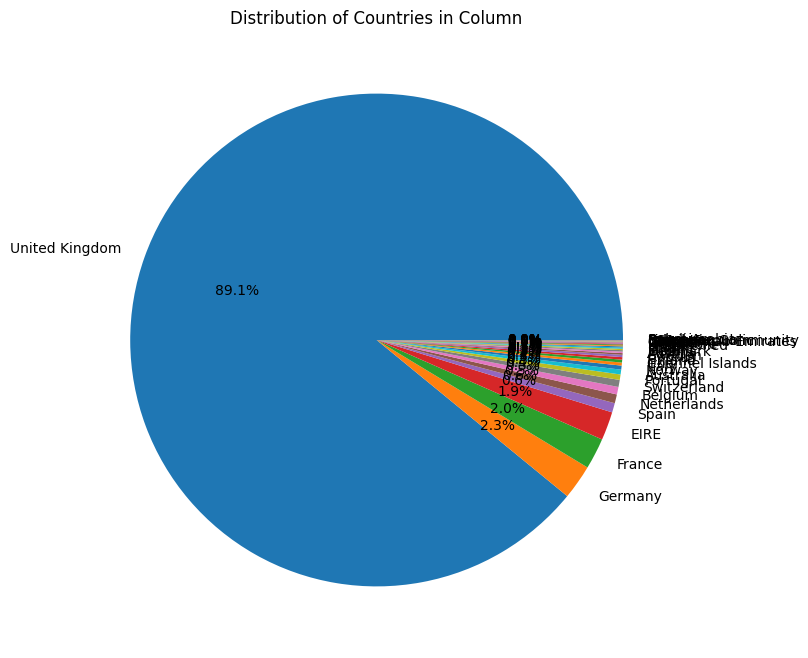

In [37]:
#location
value_counts = df['Country'].value_counts()
value_counts
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Countries in Column')
plt.show()

In [38]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1,1
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1,0
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3,0
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0,0
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2,0


# CANCELLATION 

In [39]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,Sales,Day_Of_Week,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8


In [40]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,InvoiceDate,UnitPrice,Sales,Day_Of_Week,Hour
count,8507.000000,8507,8507.000000,8507.000000,8507.000000,8507.000000
mean,-31.469613,2011-06-27 00:27:39.398142976,4.445504,-55.460293,2.246738,13.164570
min,-80995.000000,2010-12-01 09:49:00,0.030000,-168469.600000,0.000000,6.000000
25%,-6.000000,2011-03-21 16:26:00,1.450000,-16.600000,1.000000,11.000000
50%,-2.000000,2011-07-11 13:07:00,2.550000,-8.300000,2.000000,13.000000
75%,-1.000000,2011-10-06 20:38:00,4.950000,-3.300000,3.000000,15.000000
max,-1.000000,2011-12-09 11:58:00,295.000000,-0.120000,6.000000,20.000000
std,1196.981277,NaN,9.211853,2014.017603,1.567852,2.725717


In [41]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.13%


In [42]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1,1,1.0,0.5
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1,0,0.0,0.0
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3,0,0.0,0.0
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0,0,0.0,0.0
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2,0,0.0,0.0


# OUTLIER DETECTION

In [43]:
#isolation forest algorithm
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# # Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# # Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0.00,0,0.000000,1,77183.6,326,0.000000,1,1,1.0,0.5,-1,1
1,12347.0,2,7,4310.00,2458,615.714286,103,249.6,367,2.016575,1,0,0.0,0.0,1,0
2,12348.0,75,4,1437.24,2332,359.310000,21,150.0,358,10.884615,3,0,0.0,0.0,1,0
3,12349.0,18,1,1457.55,630,1457.550000,72,63.8,19,0.000000,0,0,0.0,0.0,-1,1
4,12350.0,310,1,294.40,196,294.400000,16,25.2,310,0.000000,2,0,0.0,0.0,1,0


In [44]:
#percentage of outliers
customer_data
distribution_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100
distribution_percentage

Is_Outlier
0    94.983668
1     5.016332
Name: proportion, dtype: float64

In [45]:
#remove outliers
customer_data = customer_data.loc[customer_data['Is_Outlier'] == 0]
# drop outlier features
customer_data.drop(columns = ['Outlier_Scores', 'Is_Outlier'], inplace=True)
customer_data

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate
1,12347.0,2,7,4310.00,2458,615.714286,103,249.60,367,2.016575,1,0,0.0,0.000
2,12348.0,75,4,1437.24,2332,359.310000,21,150.00,358,10.884615,3,0,0.0,0.000
4,12350.0,310,1,294.40,196,294.400000,16,25.20,310,0.000000,2,0,0.0,0.000
5,12352.0,36,8,1265.41,463,158.176250,57,38.25,297,3.132530,1,0,1.0,0.125
6,12353.0,204,1,89.00,20,89.000000,4,39.80,204,0.000000,3,0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,18280.0,277,1,180.60,45,180.600000,10,23.70,278,0.000000,0,1,0.0,0.000
4282,18281.0,180,1,80.82,54,80.820000,7,16.95,181,0.000000,6,1,0.0,0.000
4283,18282.0,7,3,176.60,98,58.866667,12,25.50,126,9.916667,4,1,1.0,1.000
4284,18283.0,3,16,2039.58,1355,127.473750,262,20.80,337,0.465181,3,1,0.0,0.000


# CORRELATION ANALYSIS

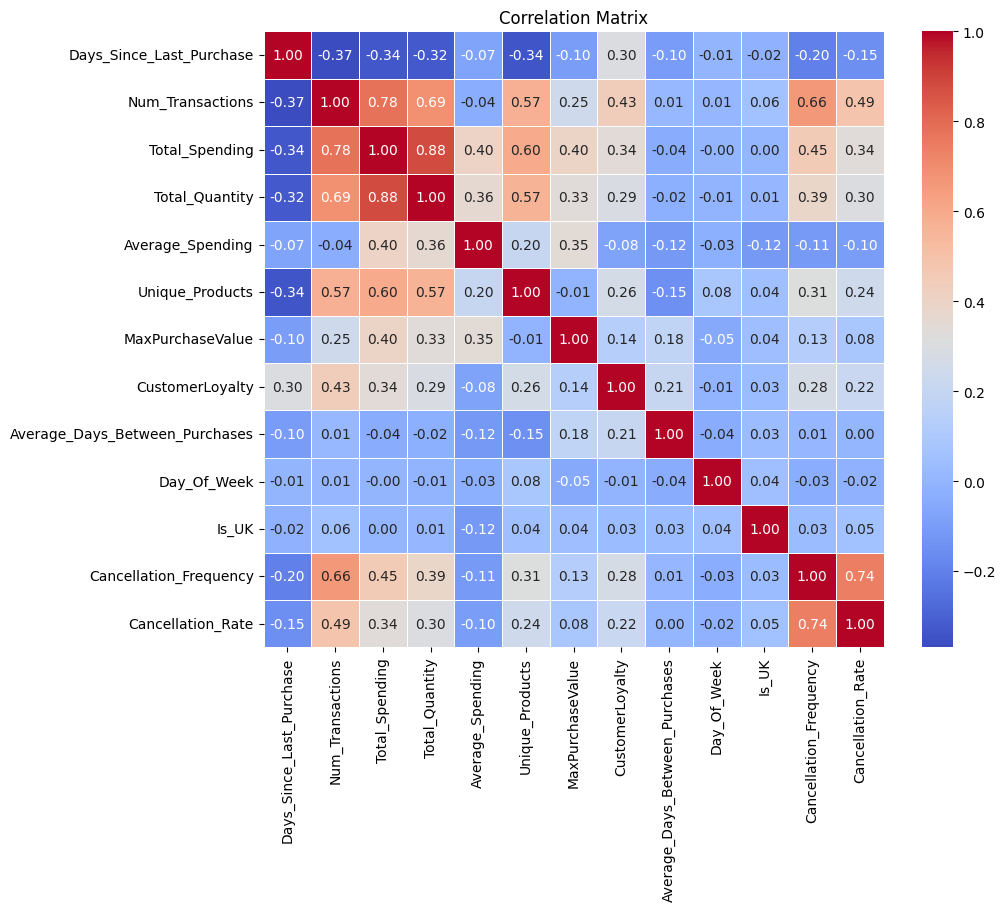

In [46]:
# Assuming customer_data is your DataFrame
# Drop the 'CustomerID' column
customer_data_without_id = customer_data.drop(columns=['CustomerID'])

# Compute the correlation matrix
correlation_matrix = customer_data_without_id.corr()

# Display the correlation matrix
# print(correlation_matrix)
correlation_matrix = customer_data_without_id.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# NORMALIZATION - SCALING

In [47]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate
1,12347.0,-0.908417,0.745992,2.318692,1.987121,1.475064,0.807298,1.589747,1.239317,-0.136439,1,0,-0.544548,-0.443894
2,12348.0,-0.173867,0.006659,0.234033,1.846646,0.317681,-0.571667,0.641462,1.162959,0.867656,3,0,-0.544548,-0.443894
4,12350.0,2.190779,-0.732674,-0.595284,-0.534732,0.024684,-0.655750,-0.546751,0.755721,-0.364768,2,0,-0.544548,-0.443894
5,12352.0,-0.566298,0.992437,0.109343,-0.237060,-0.590217,0.033732,-0.422503,0.645427,-0.010084,1,0,0.422245,-0.227448
6,12353.0,1.124173,-0.732674,-0.744336,-0.730950,-0.902471,-0.857549,-0.407746,-0.143597,-0.364768,3,0,-0.544548,-0.443894


In [48]:
customer_data.describe()

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate
count,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000,4071.000000
mean,15329.788013,92.279047,3.972980,1114.730631,675.633014,288.931645,54.994105,82.626205,220.925325,3.221588,2.559076,0.914763,0.563252,0.256354
std,1703.725747,99.392806,4.058208,1378.217665,897.069789,221.565228,59.472224,105.044571,117.881591,8.832958,1.856759,0.279268,1.034475,0.577582
min,12347.000000,0.000000,1.000000,-1192.200000,-303.000000,-1192.200000,1.000000,-122.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13872.000000,18.000000,1.000000,291.710000,152.000000,151.514000,16.000000,30.600000,107.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,15341.000000,51.000000,2.000000,616.650000,347.000000,232.840000,34.000000,49.800000,247.000000,1.213333,2.000000,1.000000,0.000000,0.000000
75%,16791.500000,143.000000,5.000000,1400.130000,843.000000,358.277500,73.000000,90.000000,324.000000,3.180797,4.000000,1.000000,1.000000,0.250000
max,18287.000000,373.000000,39.000000,14520.080000,11470.000000,2062.060000,500.000000,1790.000000,374.000000,285.000000,6.000000,1.000000,8.000000,5.000000


# PRINCIPAL COMPONENT ANALYSIS (PCA)

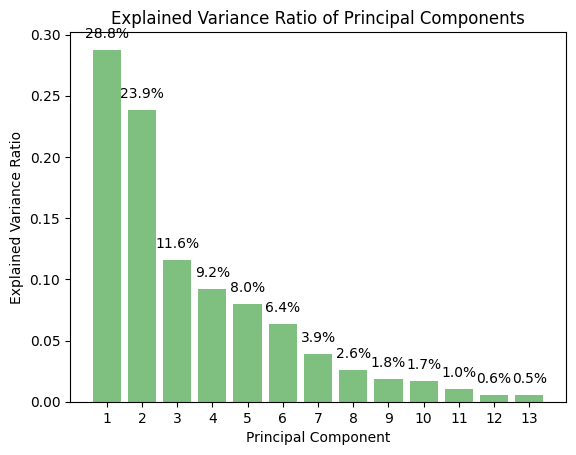

In [49]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar plot with green bars
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', color='green')

# Set custom x-axis ticks and labels for each principal component
plt.xticks(range(1, len(explained_variance_ratio) + 1))

# Add percentage values above each bar
for i, ev in enumerate(explained_variance_ratio):
    plt.text(i + 1, ev + 0.01, f'{ev*100:.1f}%', ha='center')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()


In [50]:
# PCA with 6 components
pca = PCA(n_components=6)

customer_data_pca = pca.fit_transform(customer_data_scaled)
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

customer_data_pca

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12347.0,3.063085,-1.563507,2.438302,1.099185,-0.309177,0.593688
12348.0,0.802996,0.345984,0.761682,1.610119,0.357348,0.616859
12350.0,-1.714776,-0.590682,-0.458536,1.208217,-1.751433,-0.214680
12352.0,0.583404,-1.518041,-0.788953,-0.307523,0.001031,0.777639
12353.0,-1.999754,0.420263,-0.634852,0.268320,-0.585546,-0.197425
...,...,...,...,...,...,...
18280.0,-1.885708,-2.566252,-0.719105,0.745726,-1.449160,-0.027475
18281.0,-2.029998,3.431487,-0.630888,0.110306,-0.321682,-0.216558
18282.0,-0.642926,1.390689,-1.498783,-0.874573,1.636958,-0.470132


# CLUSTERING

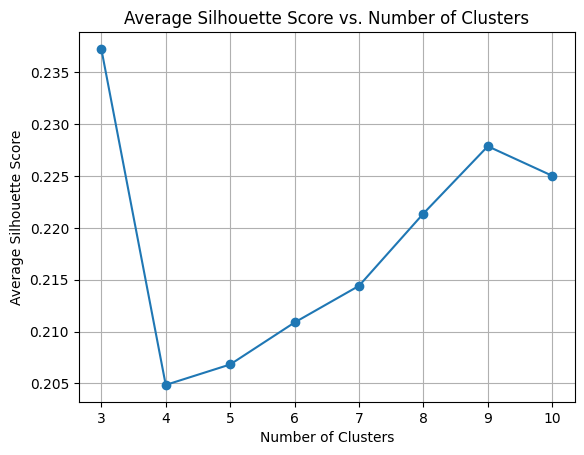

In [51]:
# Range of cluster numbers
cluster_range = range(3, 11)  # From 2 to 10 clusters

# List to store average silhouette scores
avg_silhouette_scores = []

# Compute silhouette score for each cluster number
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_data_pca)
    silhouette_avg = silhouette_score(customer_data_pca, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

# Plot line graph
plt.plot(cluster_range, avg_silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

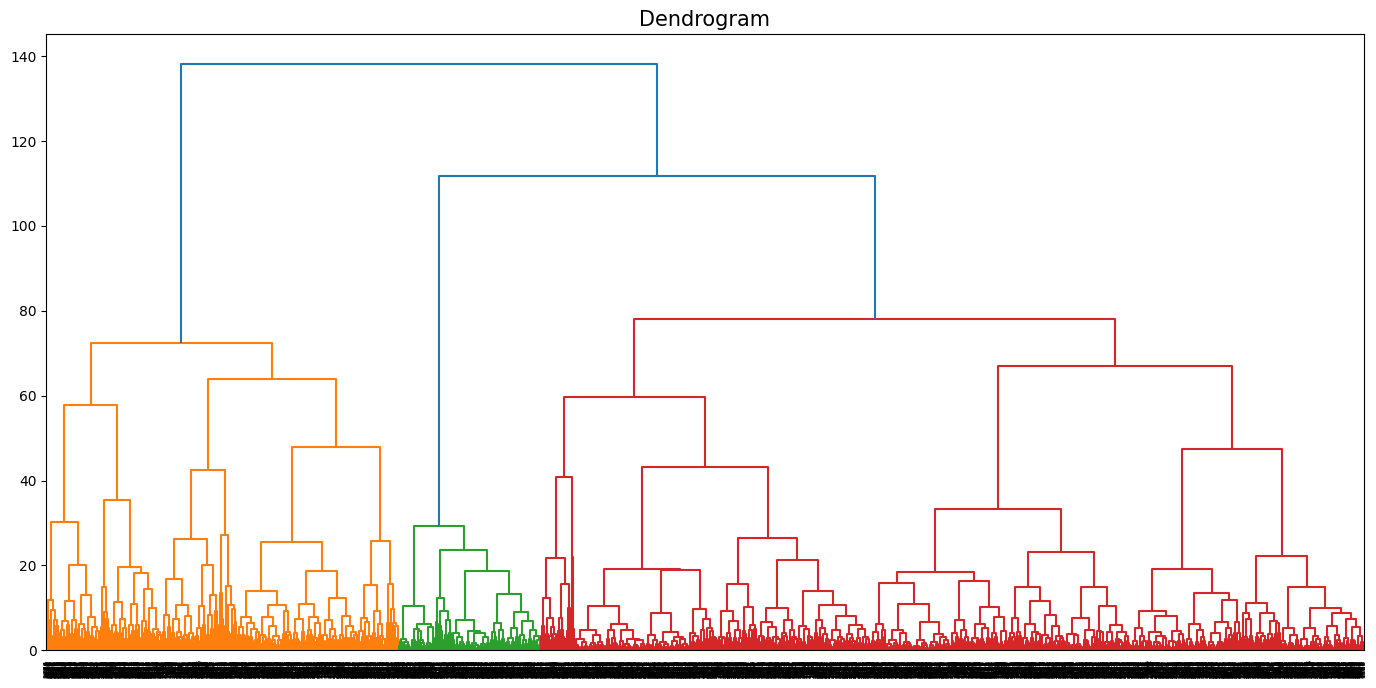

In [52]:
# Plot dendrogram
plt.figure(figsize = (17, 8))

dendro = dendrogram(linkage(customer_data_pca, method = 'ward'))
plt.title('Dendrogram', fontsize = 15)
plt.show()

In [53]:
# Using agglomerative clustering to ahcieve starting centroid point for kmeans clustering
agc_3_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
labels = agc_3_cluster.fit_predict(customer_data_pca)
# Compute centroids of each cluster from agglomerative clustering
centroids = []
for label in range(3):  # Assuming 3 clusters
    centroid = np.mean(customer_data_pca[labels == label], axis=0)
    centroids.append(centroid)

# Use centroids as initial centroids for k-means clustering
kmeans = KMeans(n_clusters=3, init=np.array(centroids), n_init=1)
kmeans.fit(customer_data_pca)

# Get final cluster labels from k-means clustering
kmeans_labels = kmeans.labels_
customer_data_3_cluster = customer_data.copy()
customer_data_pca_3_cluster = customer_data_pca.copy()
customer_data_3_cluster['Cluster'] = kmeans_labels
customer_data_pca_3_cluster['Cluster'] = kmeans_labels

customer_data_3_cluster

,CustomerID,Days_Since_Last_Purchase,Num_Transactions,Total_Spending,Total_Quantity,Average_Spending,Unique_Products,MaxPurchaseValue,CustomerLoyalty,Average_Days_Between_Purchases,Day_Of_Week,Is_UK,Cancellation_Frequency,Cancellation_Rate,Cluster
1,12347.0,2,7,4310.00,2458,615.714286,103,249.60,367,2.016575,1,0,0.0,0.000,1
2,12348.0,75,4,1437.24,2332,359.310000,21,150.00,358,10.884615,3,0,0.0,0.000,0
4,12350.0,310,1,294.40,196,294.400000,16,25.20,310,0.000000,2,0,0.0,0.000,0
5,12352.0,36,8,1265.41,463,158.176250,57,38.25,297,3.132530,1,0,1.0,0.125,0
6,12353.0,204,1,89.00,20,89.000000,4,39.80,204,0.000000,3,0,0.0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,18280.0,277,1,180.60,45,180.600000,10,23.70,278,0.000000,0,1,0.0,0.000,0
4282,18281.0,180,1,80.82,54,80.820000,7,16.95,181,0.000000,6,1,0.0,0.000,2
4283,18282.0,7,3,176.60,98,58.866667,12,25.50,126,9.916667,4,1,1.0,1.000,2
4284,18283.0,3,16,2039.58,1355,127.473750,262,20.80,337,0.465181,3,1,0.0,0.000,1


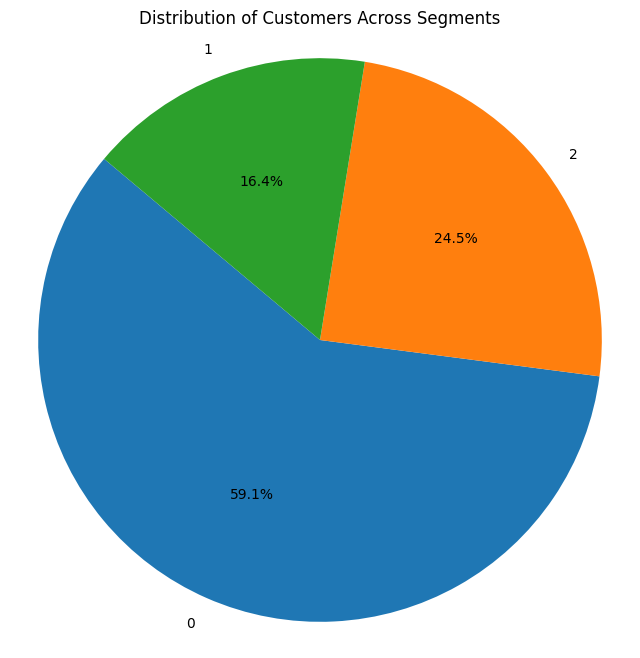

In [54]:
cluster_counts = customer_data_3_cluster['Cluster'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)

# Add title
plt.title('Distribution of Customers Across Segments')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show plot
plt.show()

In [55]:
# # 4 Clusters
# agc_4_cluster = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
# labels = agc_4_cluster.fit_predict(customer_data_pca)
# customer_data_4_cluster = customer_data.copy()
# customer_data_pca_4_cluster = customer_data_pca.copy()
# customer_data_4_cluster['Cluster'] = labels
# customer_data_pca_4_cluster['Cluster'] = labels

# customer_data_4_cluster

# TRANSITION MATRIX

In [135]:
temp = df.copy()
temp = temp[temp['Quantity'] > 0]
temp

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,Sales,Day_Of_Week,Hour,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30,2,8,Completed
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00,2,8,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34,2,8,Completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09,10.20,4,12,Completed
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09,12.60,4,12,Completed
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60,4,12,Completed
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09,16.60,4,12,Completed


In [136]:
# find earliest date of purchase
temp['InvoiceDate'] = pd.to_datetime(temp['InvoiceDate'])
earliest = temp['InvoiceDate'].min()

# create order total column
temp['OrderTotal'] = temp['Quantity'] * temp['UnitPrice']

# find the end of first quarter
three_months = earliest + pd.DateOffset(months=3)

# filter out for purchases within first quarter
q1 = temp[(temp['InvoiceDate'] >= earliest) & (temp['InvoiceDate'] <= three_months)]

# create state_df that shows each customer's state every quarter
state_df = q1.groupby('CustomerID')['OrderTotal'].sum()
state_df = state_df.reset_index()
perc80 = state_df['OrderTotal'].quantile(0.8) # find 80th percentile of total spending for that quarter
state_df['Q1'] = 'NA'
state_df.loc[state_df['OrderTotal'] >= perc80, 'Q1'] = 'Active Top 20%'
state_df.loc[state_df['OrderTotal'] < perc80, 'Q1'] = 'Active Bottom 80%'
state_df.drop(columns=['OrderTotal'], inplace=True)
state_df

,CustomerID,Q1
0,12346.0,Active Top 20%
1,12347.0,Active Top 20%
2,12348.0,Active Bottom 80%
3,12350.0,Active Bottom 80%
4,12352.0,Active Bottom 80%
...,...,...
1675,18257.0,Active Bottom 80%
1676,18259.0,Active Bottom 80%
1677,18260.0,Active Bottom 80%
1678,18269.0,Active Bottom 80%


In [137]:
# find the end of second quarter
six_months = earliest + pd.DateOffset(months=6)

# filter out for purchases within second quarter
q2 = temp[(temp['InvoiceDate'] >= three_months) & (temp['InvoiceDate'] <= six_months)]

# find each customer's total spending in second quarter
q2_purchases = q2.groupby('CustomerID')['OrderTotal'].sum()
q2_purchases = q2_purchases.reset_index()
perc80 = q2_purchases['OrderTotal'].quantile(0.8) # find 80th percentile of total spending for that quarter
q2_purchases['Q2'] = 'NA'
q2_purchases.loc[q2_purchases['OrderTotal'] >= perc80, 'Q2'] = 'Active Top 20%'
q2_purchases.loc[q2_purchases['OrderTotal'] < perc80, 'Q2'] = 'Active Bottom 80%'

# merge with state df
state_df = pd.merge(state_df, q2_purchases, how='left', on='CustomerID')
state_df['Q2'].fillna('Warm', inplace=True)
q2_purchases['Q1'] = 'NA'
state_df = pd.concat([state_df, q2_purchases]).reset_index(drop=True)
state_df = state_df.drop_duplicates(subset=['CustomerID'], keep='first')
state_df.drop(columns=['OrderTotal'], inplace=True)
state_df

,CustomerID,Q1,Q2
0,12346.0,Active Top 20%,Warm
1,12347.0,Active Top 20%,Active Bottom 80%
2,12348.0,Active Bottom 80%,Active Bottom 80%
3,12350.0,Active Bottom 80%,Warm
4,12352.0,Active Bottom 80%,Active Bottom 80%
...,...,...,...
3665,18270.0,NA,Active Bottom 80%
3666,18272.0,NA,Active Top 20%
3667,18273.0,NA,Active Bottom 80%
3668,18280.0,NA,Active Bottom 80%


In [138]:
# find the end of third quarter
nine_months = earliest + pd.DateOffset(months=9)

# filter out for purchases within third quarter
q3 = temp[(temp['InvoiceDate'] >= six_months) & (temp['InvoiceDate'] <= nine_months)]

# find each customer's total spending in third quarter
q3_purchases = q3.groupby('CustomerID')['OrderTotal'].sum()
q3_purchases = q3_purchases.reset_index()
perc80 = q3_purchases['OrderTotal'].quantile(0.8) # find 80th percentile of total spending for that quarter
q3_purchases['Q3'] = 'NA'
q3_purchases.loc[q3_purchases['OrderTotal'] >= perc80, 'Q3'] = 'Active Top 20%'
q3_purchases.loc[q3_purchases['OrderTotal'] < perc80, 'Q3'] = 'Active Bottom 80%'

# merge with state df
state_df = pd.merge(state_df, q3_purchases, how='left', on='CustomerID')
state_df['Q3'].fillna('NA', inplace=True)
state_df.loc[(state_df['Q2'] == 'Active Top 20%') & (state_df['Q3'] == 'NA'), 'Q3'] = 'Warm'
state_df.loc[(state_df['Q2'] == 'Active Bottom 80%') & (state_df['Q3'] == 'NA'), 'Q3'] = 'Warm'
state_df.loc[(state_df['Q2'] == 'Warm') & (state_df['Q3'] == 'NA'), 'Q3'] = 'Cold'
q3_purchases[['Q1', 'Q2']] = 'NA'
state_df = pd.concat([state_df, q3_purchases]).reset_index(drop=True)
state_df = state_df.drop_duplicates(subset=['CustomerID'], keep='first')
state_df.drop(columns=['OrderTotal'], inplace=True)
state_df

,CustomerID,Q1,Q2,Q3
0,12346.0,Active Top 20%,Warm,Cold
1,12347.0,Active Top 20%,Active Bottom 80%,Active Bottom 80%
2,12348.0,Active Bottom 80%,Active Bottom 80%,Warm
3,12350.0,Active Bottom 80%,Warm,Cold
4,12352.0,Active Bottom 80%,Active Bottom 80%,Warm
...,...,...,...,...
4652,18262.0,NA,NA,Active Bottom 80%
4654,18265.0,NA,NA,Active Bottom 80%
4655,18268.0,NA,NA,Active Bottom 80%
4657,18281.0,NA,NA,Active Bottom 80%


In [139]:
# filter out for purchases within last quarter
q4 = temp[temp['InvoiceDate'] >= nine_months]

# find each customer's total spending in last quarter
q4_purchases = q4.groupby('CustomerID')['OrderTotal'].sum()
q4_purchases = q4_purchases.reset_index()
perc80 = q4_purchases['OrderTotal'].quantile(0.8) # find 80th percentile of total spending for that quarter
q4_purchases['Q4'] = 'NA'
q4_purchases.loc[q4_purchases['OrderTotal'] >= perc80, 'Q4'] = 'Active Top 20%'
q4_purchases.loc[q4_purchases['OrderTotal'] < perc80, 'Q4'] = 'Active Bottom 80%'

# merge with state df
state_df = pd.merge(state_df, q4_purchases, how='left', on='CustomerID')
state_df['Q4'].fillna('NA', inplace=True)
state_df.loc[(state_df['Q3'] == 'Active Top 20%') & (state_df['Q4'] == 'NA'), 'Q4'] = 'Warm'
state_df.loc[(state_df['Q3'] == 'Active Bottom 80%') & (state_df['Q4'] == 'NA'), 'Q4'] = 'Warm'
state_df.loc[(state_df['Q3'] == 'Warm') & (state_df['Q4'] == 'NA'), 'Q4'] = 'Cold'
state_df.loc[(state_df['Q3'] == 'Cold') & (state_df['Q4'] == 'NA'), 'Q4'] = 'Inactive'
q4_purchases[['Q1', 'Q2', 'Q3']] = 'NA'
state_df = pd.concat([state_df, q4_purchases]).reset_index(drop=True)
state_df = state_df.drop_duplicates(subset=['CustomerID'], keep='first')
state_df.drop(columns=['OrderTotal'], inplace=True)
state_df

,CustomerID,Q1,Q2,Q3,Q4
0,12346.0,Active Top 20%,Warm,Cold,Inactive
1,12347.0,Active Top 20%,Active Bottom 80%,Active Bottom 80%,Active Top 20%
2,12348.0,Active Bottom 80%,Active Bottom 80%,Warm,Active Bottom 80%
3,12350.0,Active Bottom 80%,Warm,Cold,Inactive
4,12352.0,Active Bottom 80%,Active Bottom 80%,Warm,Active Bottom 80%
...,...,...,...,...,...
6268,18261.0,NA,NA,NA,Active Bottom 80%
6274,18274.0,NA,NA,NA,Active Bottom 80%
6275,18276.0,NA,NA,NA,Active Bottom 80%
6276,18277.0,NA,NA,NA,Active Bottom 80%
